In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from pylab import rcParams
from keras.models import Sequential
from keras.layers import Dense, Dropout

%matplotlib inline

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

Using TensorFlow backend.


# Loading the data

The dataset we're going to use can be downloaded from [Kaggle](https://www.kaggle.com/dalpozz/creditcardfraud). It contains data about credit card transactions that occurred during a period of two days, with 492 frauds out of 284,807 transactions.

All variables in the dataset are numerical. The data has been transformed using PCA transformation(s) due to privacy reasons. The two features that haven't been changed are Time and Amount. Time contains the seconds elapsed between each transaction and the first transaction in the dataset.

In [5]:
df = pd.read_csv("E:\\INSOFE\\AI and Deep Learning\\fraud_detection\\creditcard.csv")

# Exploration

In [6]:
df.shape

(284807, 31)

31 columns, 2 of which are Time and Amount. The rest are output from the PCA transformation. Let's check for missing values:

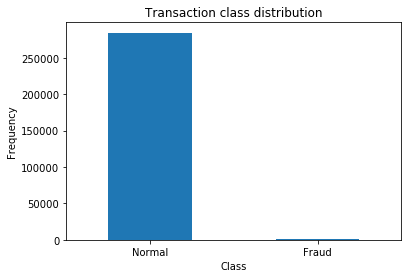

In [7]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

# Preparing the data

First, let's drop the Time column (not going to use it) and use the scikit's StandardScaler on the Amount. The scaler removes the mean and scales the values to unit variance:

In [9]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

Training our Autoencoder is gonna be a bit different from what we are used to. Let's say you have a dataset containing a lot of non fraudulent transactions at hand. You want to detect any anomaly on new transactions. We will create this situation by training our model on the normal transactions, only. Reserving the correct class on the test set will give us a way to evaluate the performance of our model. We will reserve 20% of our data for testing:

In [10]:
from sklearn.model_selection import train_test_split

data = np.array(data)

X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train[:,-1] == 0]
X_train = X_train[:,:-1]

y_test = X_test[:,-1]
X_test = X_test[:,:-1]

In [11]:
X_train.shape

(227451, 29)

# Building the model

Building an autoencoder with 100 hidden layer neurons.

In [12]:
input_dim = X_train.shape[1]
encoding_dim = 15

In [13]:
autoencoder = Sequential()

autoencoder.add(Dropout(0.2, input_shape=(input_dim,)))
autoencoder.add(Dense(20, activation='sigmoid'))
autoencoder.add(Dense(encoding_dim, activation='relu'))

#Decoders
autoencoder.add(Dense(20, activation='sigmoid'))
autoencoder.add(Dense(input_dim, activation='linear'))

Let's train our model for 100 epochs with a batch size of 32 samples and save the best performing model to a file.

In [14]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['mse'])

In [15]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_1 (Dropout)          (None, 29)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                600       
_________________________________________________________________
dense_2 (Dense)              (None, 15)                315       
_________________________________________________________________
dense_3 (Dense)              (None, 20)                320       
_________________________________________________________________
dense_4 (Dense)              (None, 29)                609       
Total params: 1,844
Trainable params: 1,844
Non-trainable params: 0
_________________________________________________________________


In [16]:
hist = []
for _ in range(100):
    hist.append(autoencoder.fit(X_train, X_train,
                    epochs=1,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1).history)

Train on 227451 samples, validate on 56962 samples
Epoch 1/1
227451/227451 [==============================] - 16s - loss: 0.6210 - mean_squared_error: 0.6210 - val_loss: 0.4427 - val_mean_squared_error: 0.4427
Train on 227451 samples, validate on 56962 samples
Epoch 1/1
227451/227451 [==============================] - 15s - loss: 0.4539 - mean_squared_error: 0.4539 - val_loss: 0.3727 - val_mean_squared_error: 0.3727
Train on 227451 samples, validate on 56962 samples
Epoch 1/1
227451/227451 [==============================] - 15s - loss: 0.4060 - mean_squared_error: 0.4060 - val_loss: 0.3242 - val_mean_squared_error: 0.3242
Train on 227451 samples, validate on 56962 samples
Epoch 1/1
227451/227451 [==============================] - 15s - loss: 0.3692 - mean_squared_error: 0.3692 - val_loss: 0.2982 - val_mean_squared_error: 0.2982
Train on 227451 samples, validate on 56962 samples
Epoch 1/1
227451/227451 [==============================] - 15s - loss: 0.3504 - mean_squared_error: 0.3504 - 

KeyboardInterrupt: 

In [17]:
_hist_ = [(x['loss'][0], x['val_loss'][0]) for x in hist]

In [20]:
# autoencoder.save('fraud_detection.h5') this can be used to save the output of the autoencoder,
#so that when we want to use output again we can directly load the output valuewithout trainng it again
from keras.models import load_model
aec = load_model('E:\\INSOFE\\AI and Deep Learning\\fraud_detection\\fraud_detection.h5') #used to 

E:\Anaconda3\lib\site-packages\keras\models.py:287: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


# Evaluation

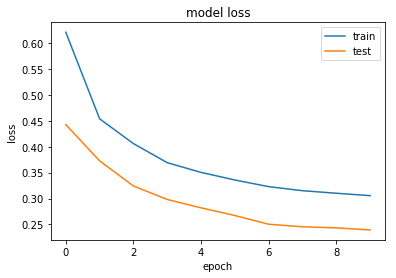

In [21]:
plt.plot(list(zip(*_hist_))[0])
plt.plot(list(zip(*_hist_))[1])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

The reconstruction error on our training and test data seems to converge nicely. Is it low enough? Let's have a closer look at the error distribution:

In [22]:
predictions = aec.predict(X_train)
recon  = (((predictions-X_train)**2).mean(-1))

test_pred = autoencoder.predict(X_test)
test_recon  = (((test_pred-X_test)**2).mean(-1))

mean_recon = recon.mean()

In [23]:
from sklearn.metrics import precision_score,recall_score

prc = list()
rec = list()
thres = list()

th = 0
for i in range(100):
    th+=0.1
    fraud = (test_recon>mean_recon+th)
    prc.append(precision_score(y_test,fraud))
    rec.append(recall_score(y_test,fraud))
    thres.append(th)
    

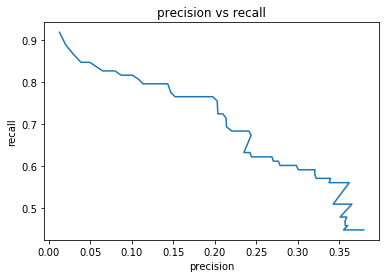

In [24]:
plt.plot(prc, rec)
plt.title('precision vs recall')
plt.ylabel('recall')
plt.xlabel('precision')

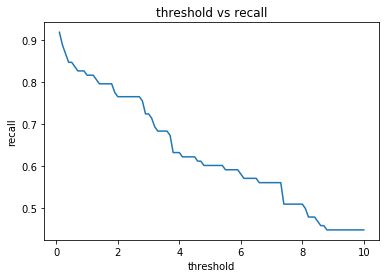

In [25]:
plt.plot(thres, rec)
plt.title('threshold vs recall')
plt.ylabel('recall')
plt.xlabel('threshold')

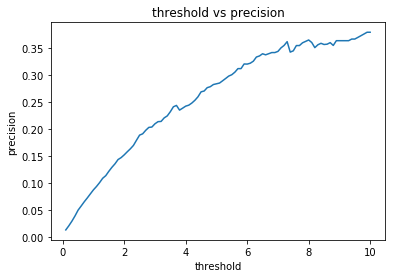

In [26]:
plt.plot(thres, prc)
plt.title('threshold vs precision')
plt.ylabel('precision')
plt.xlabel('threshold')